# Módulo 5: Introducción a las RNN y el PLN en PyTorch

Hasta ahora, no hemos aplicado las capacidades de PyTorch para resolver problemas de procesamiendo del lenguaje natural (PLN). El campo del PLN es un ámbito muy emocionante en el que aplicar las técnicas de *deep learning*. Al igual que sucede con la visión artificial, existen diferentes tipos de problemas de PLN. Entre ellos, la clasificación, el resumen y el mapeado secuencia a secuencia. Por último, queremos implementar un modelo que resuelva un problema muy habitual de mapeado secuencia a secuencia: la traducción automática. Sin embargo, para desarrollar las herramientas de PLN necesarias, antes examinaremos tareas más sencillas, como completar tareas y frases.

## Definición del problema

Los problemas de mapeado secuencia a secuencia son, por su propia naturaleza, diferentes de las tareas de aprendizaje que hemos resuelto hasta ahora. En la clasificación de imágenes, existe una etiqueta de clase diferenciada, una correspondencia uno a uno entre el *input* y el *output*. En el mapeado secuencia a secuencia, el *input* consiste en muchas muestras discretas o, en este caso, caracteres. Además, el *output* es también una secuencia de caracteres.

## Conjunto de datos

Utilizaremos una base de datos de pares de frases en inglés y español. Más adelante, utilizaremos el mismo conjunto para una tarea de traducción automática, pero de momento solo nos interesa examinar las frases en inglés. 

El tutorial de PyTorch [NLP From Scratch](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html) utiliza un conjunto de datos en inglés y francés para realizar una tarea de traducción, y fue lo que nos inspiró a utilizar este conjunto. Realizaremos un proceso de limpieza de datos y aplicaremos funciones de utilidad similares a las del tutorial.

In [1]:
from io import open
import unicodedata
import string
import random
import re

import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Subset
from torch.utils.data import TensorDataset, DataLoader
import time, copy
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

In [2]:
# Descargar y descomprimir el archivo de texto que contiene todas las frases traducidas
!rm spa-eng.zip _about.txt spa.txt
!wget https://www.manythings.org/anki/spa-eng.zip
!unzip spa-eng.zip
!ls

rm: cannot remove 'spa-eng.zip': No such file or directory
rm: cannot remove '_about.txt': No such file or directory
rm: cannot remove 'spa.txt': No such file or directory
--2023-01-17 19:54:58--  https://www.manythings.org/anki/spa-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5336731 (5,1M) [application/zip]
Saving to: ‘spa-eng.zip’

spa-eng.zip         100%[===================>]   5,09M  1,60MB/s    in 3,2s    

2023-01-17 19:55:04 (1,60 MB/s) - ‘spa-eng.zip’ saved [5336731/5336731]

Archive:  spa-eng.zip
  inflating: _about.txt              
  inflating: spa.txt                 
10-CNNs.ipynb			  7-pytorch-ejemplo.ipynb
11-TAREA-FashionMNIST.ipynb	  8-TAREA-MNIST.ipynb
12-Transfer_Learning.ipynb	  9-Autoencoders.ipynb
13-RNNs-NLP.ipynb		  abalone.data
1-grad_desc.ipynb		  abalone.names
2-gradiente.ipynb		  _abou

Estas funciones de ayuda limpian el conjunto de datos para garantizar que la red neuronal pueda utilizar las frases. Para obtener más información, visite el enlace que aparece en el siguiente comentario.

In [4]:
# Funciones de ayuda combinadas del tutorial de PyTorch: https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

# Convertir una string de Unicode a ASCII plano, gracias a
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Convertir los caracteres a minúsculas, recortar y eliminar todos los caracteres que no sean letras
# Este paso es importante para que todas las palabras tengan el mismo formato,
# igual que sucede al normalizar imágenes
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r"", s)
    s = re.sub(r"[^a-zA-Z.!'?]+", r" ", s)
    return s

def parse_data(filename):
    # Leer el archivo y dividir en líneas
    lines = open(filename, encoding='utf-8').read().strip().split('\n')

    # Dividir cada línea en pares y normalizar
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
    # Eliminar la atribución, porque no forma parte de los datos
    pairs = [[pair[0], pair[1]] for pair in pairs]

    return pairs

In [5]:
pairs = parse_data("spa.txt")
# Solo nos interesan las frases en inglés, porque no vamos a traducir
english_sentences = [pair[0] for pair in pairs]
# Mezclar el conjunto de datos
random.shuffle(english_sentences)
print("Number of English sentences:", len(english_sentences))

Number of English sentences: 139013


In [6]:
# Incluiremos todas las letras ascii y algunos caracteres habituales en el conjunto de caracteres válidos
letters = string.ascii_letters + " .,;'-"
num_letters = len(letters) + 1 # Tenemos que añadir 1 para tener en cuenta la etiqueta "Fin"

In [7]:
print(string.ascii_letters)

abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ


## Completar palabras

Para la primera ronda, vamos a tomar una muestra de las palabras que aparecen en las frases y a predecir palabras completas a partir de un subconjunto de caracteres.

In [8]:
# Reducir las frases a palabras y eliminar '.'
words = [word for sentence in english_sentences for word in sentence.split(' ') if word not in ['.', '!', '?'] and len(word) > 0 and '\'' not in word]

# Como ya hemos mezclado el conjunto de datos, tomamos una muestra aleatoria de palabras para los subconjuntos de entrenamiento, validación y prueba
train_words = words[:20000]
val_words = words[20000:25000]
test_words = words[25000:30000]

In [9]:
print(train_words[:100])

['have', 'a', 'nice', 'weekend', 'we', 'came', 'together', 'just', 'let', 'me', 'sleep', 'i', 'have', 'no', 'time', 'for', 'games', 'stop', 'asking', 'so', 'many', 'questions', 'tom', 'told', 'me', 'that', 'he', 'spoke', 'french', 'he', 'had', 'a', 'stroke', 'tom', 'went', 'out', 'to', 'eat', 'why', 'are', 'you', 'two', 'always', 'fighting', 'tom', 'stood', 'up', 'again', 'i', 'heard', 'you', 'were', 'back', 'in', 'town', 'tom', 'fed', 'his', 'dog', 'table', 'scraps', 'tom', 'sprained', 'his', 'ankle', 'terrible', 'advice', 'koko', 'is', 'a', 'female', 'gorilla', 'old', 'soldiers', 'never', 'die', 'they', 'just', 'fade', 'away', 'this', 'will', 'keep', 'you', 'warm', 'i', 'want', 'you', 'to', 'understand', 'my', 'situation', 'could', 'you', 'please', 'explain', 'it', 'once', 'more', 'i']


### Codificación

Ahora que tenemos todas las palabras en formato de *string*, debemos codificarlas en una representación que la red neuronal pueda interpretar. Crearemos un vector de codificación *one-hot* para cada caracter, y los encadenaremos para que representen una palabra específica para las muestras de *input* de entrenamiento.

Puesto que estamos utilizando una RNN, introduciremos estos vectores de caracteres de uno en uno. El objetivo de la RNN es predecir el *siguiente* caracter de la palabra. Eso permite a la red generar una palabra a partir de una única letra o un prefijo. Además, necesitamos que la red aprenda cuándo termina una palabra. Para ello, designaremos un caracter especial al final de cada secuencia (EOS) que se debería predecir a partir del último caracter de una palabra.

Designaremos dos secuencias de tensores. En primer lugar, el `input_tensor`, que se representa como una concatenación de los vectores de codificación *one-hot* para cada caracter. La segunda secuencia de tensores, `target_tensor`, contiene el vector de codificación *one-hot* para los caracteres de la secuencia de *output*.

Por lo tanto, la secuencia objetivo será la codificación de `input_word[1:]` más un símbolo adicional que represente el final de la palabra.Esto alinea cada uno de los vectores de codificación *one-hot* de la muestra de *input* de entrenamiento con el vector de codificación *one-hot* que está intentando predecir.

In [10]:
# Crear las muestras de entrenamiento:

# Adaptado de https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html
# Matriz one-hot de letras de la primera a la última (sin incluir EOS) como input
def input_tensor(word):
    tensor = torch.zeros(len(word), 1, num_letters)
    for idx in range(len(word)):
        letter = word[idx]
        tensor[idx][0][letters.find(letter)] = 1
    return tensor

# LongTensor desde la segunda letra al final (EOS) como objetivo
def target_tensor(word):
    tensor = torch.zeros(len(word), 1, num_letters)
    for idx in range(1, len(word)):
        letter = word[idx]
        tensor[idx-1][0][letters.find(letter)] = 1
    tensor[len(word)-1][0][num_letters-1] = 1 # EOS
    return tensor

train_input = [input_tensor(word) for word in train_words]
train_target = [target_tensor(word) for word in train_words]
val_input = [input_tensor(word) for word in val_words]
val_target = [target_tensor(word) for word in val_words]
test_input = [input_tensor(word) for word in test_words]
test_target = [target_tensor(word) for word in test_words]

In [11]:
# Veamos el aspecto que tienen las codificaciones de las palabras
for i in range(6):
    print(train_words[i], "[encode as]", train_input[i])

have [encode as] tensor([[[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0.]],

        [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

In [12]:
def input_tensor_to_word(tensor):
    word = ""
    for i in range(tensor.size(0)):
        topv, topi = tensor[i].topk(1)
        word += letters[topi[0][0]]
    return word

def target_tensor_to_word(tensor):
    word = ""
    for i in range(tensor.size(0)):
        topv, topi = tensor[i].topk(1)
        if topi[0][0] == num_letters-1:
            word += "<EOS>"
            break
        word += letters[topi[0][0]]
    return word
print("This code helps visualize what an input and its corresponding target should look like!")
for input, target in zip(train_input, train_target):
    print(input_tensor_to_word(input))
    print(target_tensor_to_word(target))
    break


This code helps visualize what an input and its corresponding target should look like!
have
ave<EOS>


In [13]:
dataloaders = {'train': list(zip(train_input, train_target)),
               'val': list(zip(val_input, val_target)),
               'test': list(zip(test_input, test_target))}

dataset_sizes = {'train': len(train_input),
                 'val': len(val_input),
                 'test': len(test_input)}
print(f'dataset_sizes = {dataset_sizes}')

dataset_sizes = {'train': 20000, 'val': 5000, 'test': 5000}


### Definición de la RNN

Para completar esta actividad, crearemos una implementación básica de una red neuronal recurrente (RNN). Afortunadamente, PyTorch incluye una muy buena implementación de un módulo RNN. Lo utilizaremos y modificaremos nuestro método `forward` estándar para que tenga en cuenta el estado oculto.

Al utilizar una RNN, la red neuronal es capaz de generar predicciones de secuencias de caracteres. Se modificará ligeramente el *feedforward* para incluir un estado oculto que codifique información sobre la secuencia actual que la red neuronal ya ha visto. Además del estado oculto codificado, el *output* del *feedforward* será la probabilidad predicha del proximo carácter de la secuencia.

El entrenamiento será ligeramente diferentes, ya que la red predecirá probabilidades sobre el próximo carácter de la secuencia. Por lo tanto, haremos un seguimiento de la pérdida para toda una secunecia antes de realizar la retropropagación. En la siguiente sección, lo explicaremos con más detalle.


In [15]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.rnn = nn.RNN(input_size, hidden_size, num_layers = 1, nonlinearity = 'tanh', dropout = 0)

        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):

        output, hidden = self.rnn(input, hidden)
        output = self.fc(output)

        return output, hidden
    
    # Este método nos dará un tensor de estado oculto para la predicción inicial de la secuencia
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [16]:
# Para esta red, utilizaremos un tamaño oculto de 128
word_rnn = RNN(num_letters, 128, num_letters).to(device)

In [17]:
print(word_rnn)

RNN(
  (rnn): RNN(59, 128)
  (fc): Linear(in_features=128, out_features=59, bias=True)
)


### Entrenamiento

Entrenar el modelo será un proceso muy similar a las tareas de clasificación que hemos completado en otras ocasiones. Sin embargo, ahora tendremos que tener en cuenta la secuencia de *inputs* y predicciones. Al entrenar, calcularemos la pérdida de toda una secuencia (palabra) y aplicaremos la retropropagación de cada secuencia dada.

Podemos definir así los pasos necesarios:

1. Inicializar el estado oculto - Cada llamada de `forward` requiere una codificación de estado oculto. Hemos decidido que nuestra codificación inicial de estado oculto para el primer caracter de una secuencia es un tensor `zeros`.

2. Completar ciclos del `input_tensor` y aplicar los siguientes pasos a cada carácter de la secuencia:

    a. Llamar a `forward` con la codificación del carácter actual y el `hidden_state`actual.

    b. `forward` generará como *output* una distribución de probabilidad del próximos carácter predicho y un nuevo `hidden_state`

    c. Calcular la pérdida de la distribución del *output* de probabilidad del siguiente carácter respecto al siguiente carácter *ground truth* de la secuencia y sumarla al total en curso.

    d. Pasar al siguiente carácter de la secuencia de *input* utilizando el último `hidden_state`
    
3. Una vez que todos los caracteres de la secuencia hayan pasado por la función `forward`, realizar la retropropagación dada la pérdida entera de la secuencia y rehacer este proceso para la siguiente secuencia.

Nota: se ha actualizado la función de entrenamiento para representar este nuevo flujo de trabajo. Intente seguir las isntrucciones que aparecen en los comentarios del código para ver cómo hemos implementado este nuevo proceos en Python.



In [ ]:
def train_rnn(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict()) # Almacenar los mejores pesos por separado
    best_loss = np.inf
    best_epoch = 0

    # Cada ciclo tiene una fase de entrenamiento, validación y prueba
    phases = ['train', 'val', 'test']
    
    # Hacer un seguimiento de la evolución de la pérdida durante el entrenamiento
    training_curves = {}
    for phase in phases:
        training_curves[phase+'_loss'] = []
    
    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in phases:
            if phase == 'train':
                model.train()  # Configurar el modelo en modo de entrenamiento
            else:
                model.eval()   # Configurar el modelo en modo de evaluación
                
            running_loss = 0.0

           # Iterar con los datos
            for input_sequence, target_sequence in dataloaders[phase]:
                # Ahora, iterar con cada secuencia

                hidden = model.initHidden() # Empezar con un estado oculto nuevo

                current_input_sequence = input_sequence.to(device)
                current_target_sequence = target_sequence.to(device)

                # Poner a cero los gradientes de los parámetros
                optimizer.zero_grad()

                # Método forward
                with torch.set_grad_enabled(phase == 'train'):
                    loss = 0
                    # Hacer una predicción de cada elemento de la secuencia,
                    # y llevar un seguimiento del estado oculto a lo largo del proceso
                    for i in range(current_input_sequence.size(0)):
                        # Debemos pensar bien cómo transferir las capas ocultas al dispositivo
                        current_hidden = hidden.to(device)
                        output, hidden = model(current_input_sequence[i], current_hidden)
                        l = criterion(output, current_target_sequence[i])
                        loss += l

                    # Método backward y actualización de los pesos solo si está en la fase de entrenamiento al final de una secuencia
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Estadísticas
                running_loss += loss.item() / current_input_sequence.size(0)
 
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            training_curves[phase+'_loss'].append(epoch_loss)

            print(f'{phase:5} Loss: {epoch_loss:.4f}')

            # Hacer una copia profunda del modelo si es la mejor pérdida
            # Nota: utilizamos la pérdida de entrenamiento para seleccionar el mejor modelo
            if phase == 'train' and epoch_loss < best_loss:
              best_epoch = epoch
              best_loss = epoch_loss
              best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Loss: {best_loss:4f} at epoch {best_epoch}')

    # Cargar los mejores pesos del modelo
    model.load_state_dict(best_model_wts)
    
    return model, training_curves

In [ ]:
# Debería tener un aspecto muy similar al de tareas anteriores
learning_rate = 0.001
num_epochs = 10 # Solo vamos a aplicar 10 ciclos para ahorrar tiempo, pero puede utilizar más si quiere

In [ ]:
# El código es muy similar al de modelos de entrenamiento anteriores no recurrentes
# Pérdida y optimizador
criterion = nn.CrossEntropyLoss() # Utilizar CrossEntropyLoss para la clasificación.
optimizer = torch.optim.Adam(word_rnn.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

# Entrenar el modelo. También almacenaremos los resultados del entrenamiento para poder visualizarlos
word_rnn, training_curves = train_rnn(word_rnn, dataloaders, dataset_sizes, 
                                     criterion, optimizer, scheduler, num_epochs=num_epochs)


Epoch 1/10
----------
train Loss: 1.6566
val   Loss: 1.4036
test  Loss: 1.4166

Epoch 2/10
----------
train Loss: 1.3388
val   Loss: 1.2824
test  Loss: 1.2946

Epoch 3/10
----------
train Loss: 1.2420
val   Loss: 1.2191
test  Loss: 1.2260

Epoch 4/10
----------
train Loss: 1.1889
val   Loss: 1.1915
test  Loss: 1.1973

Epoch 5/10
----------
train Loss: 1.1566
val   Loss: 1.1703
test  Loss: 1.1749

Epoch 6/10
----------
train Loss: 1.1315
val   Loss: 1.1472
test  Loss: 1.1509

Epoch 7/10
----------
train Loss: 1.1124
val   Loss: 1.1360
test  Loss: 1.1387

Epoch 8/10
----------
train Loss: 1.0966
val   Loss: 1.1283
test  Loss: 1.1296

Epoch 9/10
----------
train Loss: 1.0838
val   Loss: 1.1217
test  Loss: 1.1228

Epoch 10/10
----------
train Loss: 1.0714
val   Loss: 1.1124
test  Loss: 1.1120

Training complete in 14m 3s
Best val Loss: 1.071431 at epoch 9


### Visualizar los resultados

Podemos visualizar la curva de entrenamiento, igual que en las tareas anteriores. Parece que, después de 10 ciclos, el modelo no se sobreajusta, lo que significa que probablemente podríamos entrenarlo durante más tiempo.

In [ ]:
def plot_training_curves(training_curves, 
                         phases=['train', 'val', 'test'],
                         metrics=['loss']):
    epochs = list(range(len(training_curves['train_loss'])))
    for metric in metrics:
        plt.figure()
        plt.title(f'Training curves - {metric}')
        for phase in phases:
            key = phase+'_'+metric
            if key in training_curves:
                plt.plot(epochs, training_curves[key])
        plt.xlabel('epoch')
        plt.legend(labels=phases)

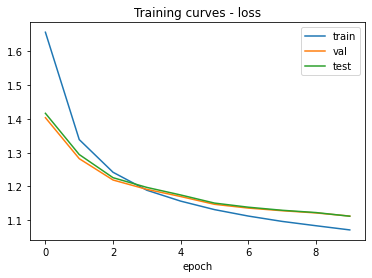

In [ ]:
plot_training_curves(training_curves, phases=['train', 'val', 'test'])

### Generar palabras

Más abajo, hemos incluido una función que ejecuta la red sobre una secuencia de *input* especificada, que podría ser una letra o parte de una palabra. Encontrará también algunos ejemplos, puede utilizarlos para conocer la palabra que predice la red.

Los resultados de esta red dependerán, en gran medida, de la muestra aleatoria de frases que se le dieran al principio. Cuanto más aparezca una palabra concreta en los datos de entrenamiento, más probable es que aparezca en la predicción. Funciona de manera muy similar a las sugerencias de palabras del teclado de los *smartphones*.

In [ ]:
def predict(model, input_letters, max_length = 50):
    output_word = input_letters
    tensor = input_tensor(input_letters)
    hidden = model.initHidden()
    current_input_sequence = tensor.to(device)
    input = None

    for i in range(current_input_sequence.size(0)):
        current_hidden = hidden.to(device)
        output, hidden = model(current_input_sequence[i], current_hidden)

    topv, topi = output.topk(1)
    topi = topi[0][0]
    if topi == num_letters - 1:
        # Imprimir("Most likely word was our initial letters, grab the second most likely")
        topv, topi = output.topk(2)
        topi = topi[0][1]
    letter = letters[topi]
    output_word += letter
    input = input_tensor(letter)

    for i in range(len(input_letters), max_length):
        current_hidden = hidden.to(device)
        current_input = input[0].to(device)
        output, hidden = model(current_input, current_hidden)
        topv, topi = output.topk(1)
        topi = topi[0][0]
        if topi == num_letters - 1:
            # Imprimir("Hit the EOS")
            break
        letter = letters[topi]
        output_word += letter
        input = input_tensor(letter)
    return output_word

In [ ]:
print(predict(word_rnn, "ha"))
print(predict(word_rnn, "al"))
print(predict(word_rnn, "c"))

have
along
could



## Completar frases

Ahora, nos centraremos en la tarea de completar frases. Es un proceso relativamente sencillo, porque seguiremos trabajando con codificaciones *one-hot* de secuencias de caracteres. Existen otras formas más sofisticadas de codificar las muestras de entrenamiento. Las veremos más adelante.

In [ ]:
train_sentences = english_sentences[:1000]
val_sentences = english_sentences[1000:2000]
test_sentences = english_sentences[2000:3000]

### Codificación

Esta codificación es muy sencilla. Usaremos la misma función que antes, pero ahora para operar en toda la frase en vez de en una palabra.

In [ ]:
train_input_sentence = [input_tensor(sentence) for sentence in train_sentences]
train_target_sentence = [target_tensor(sentence) for sentence in train_sentences]
val_input_sentence = [input_tensor(sentence) for sentence in val_sentences]
val_target_sentence = [target_tensor(sentence) for sentence in val_sentences]
test_input_sentence = [input_tensor(sentence) for sentence in test_sentences]
test_target_sentence = [target_tensor(sentence) for sentence in test_sentences]

In [ ]:
dataloaders_sentences = {'train': list(zip(train_input_sentence, train_target_sentence)),
               'val': list(zip(val_input_sentence, val_target_sentence)),
               'test': list(zip(test_input_sentence, test_target_sentence))}

dataset_sizes_sentences = {'train': len(train_input_sentence),
                 'val': len(train_input_sentence),
                 'test': len(train_input_sentence)}
print(f'dataset_sizes = {dataset_sizes_sentences}')

dataset_sizes = {'train': 1000, 'val': 1000, 'test': 1000}


### Definición de la RNN

Además, podemos utilizar la misma arquitectura, solo necesitamos una capa oculta más grande porque las secuencias serán más largas.

In [ ]:
# RNN más grande
sentences_rnn = RNN(num_letters, 256, num_letters).to(device)

### Entrenamiento

Ahora, entrenaremos durante otros 10 ciclos. Entrenar modelos recurrentes normalmente lleva mucho tiempo. El aumento de ciclos debería mejorar el rendimiento del modelo.

In [ ]:
# Este proceso debería parecerse mucho a tareas anteriores
learning_rate = 0.001
num_epochs = 10 # Solo completamos 10 ciclos para ahorrar tiempo, pero puede completar más si quiere

In [ ]:
# Pérdida y optimizador
criterion = nn.CrossEntropyLoss() # Utilizar CrossEntropyLoss para la clasificación
optimizer = torch.optim.Adam(sentences_rnn.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

# Entrenar el modelo. También almacenaremos los resultados del entrenamiento para poder visualizarlos
sentences_rnn, training_curves_sentences = train_rnn(sentences_rnn, dataloaders_sentences, dataset_sizes, 
                                     criterion, optimizer, scheduler, num_epochs=num_epochs)


Epoch 1/10
----------
train Loss: 0.1289
val   Loss: 0.4593
test  Loss: 0.4616

Epoch 2/10
----------
train Loss: 0.1097
val   Loss: 0.4392
test  Loss: 0.4405

Epoch 3/10
----------
train Loss: 0.1039
val   Loss: 0.4243
test  Loss: 0.4252

Epoch 4/10
----------
train Loss: 0.0999
val   Loss: 0.4111
test  Loss: 0.4112

Epoch 5/10
----------
train Loss: 0.0963
val   Loss: 0.4033
test  Loss: 0.4029

Epoch 6/10
----------
train Loss: 0.0931
val   Loss: 0.3987
test  Loss: 0.3979

Epoch 7/10
----------
train Loss: 0.0902
val   Loss: 0.3943
test  Loss: 0.3936

Epoch 8/10
----------
train Loss: 0.0873
val   Loss: 0.3934
test  Loss: 0.3928

Epoch 9/10
----------
train Loss: 0.0846
val   Loss: 0.3912
test  Loss: 0.3906

Epoch 10/10
----------
train Loss: 0.0820
val   Loss: 0.3901
test  Loss: 0.3899

Training complete in 5m 51s
Best val Loss: 0.082030 at epoch 9


### Visualizar los resultados

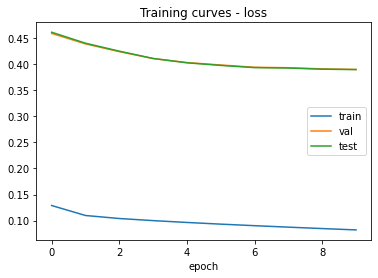

In [ ]:
plot_training_curves(training_curves_sentences, phases=['train', 'val', 'test'])

### Generar frases

Podemos utilizar la misma función en el nuevo modelo para generar frases. Pruebe algunos de estos ejemplos:

In [ ]:
print(predict(sentences_rnn, "I ate a "))

I ate a what to way


In [ ]:
print(predict(sentences_rnn, "What is"))

What is a but to the pooner what tom wint to to sou


In [ ]:
print(predict(sentences_rnn, "My name is"))

My name is a bot me to the poon


In [ ]:
print(predict(sentences_rnn, "Ha"))

Hat i don't loke to the poon


In [ ]:
print(predict(sentences_rnn, "A"))

Ao look do bust of the pack


## Conclusión

En este cuaderno, hemos aprendido a aplicar las redes neuronales profundas para resolver distintas tareas secuenciales basadas en la predicción. Los resultados obtenidos al completar frases demuestran que la red no puede producir resultados especialmente inteligentes. En futuros cuadernos, examinaremos formas de mejorar los modelos y resolver tareas más complejas, como la traducción automática. 

Entre los métodos que permiten mejorar el rendimiento están el uso de conjuntos de datos más grandes, el aumento del tiempo de entrenamiento, las incrustaciones más inteligentes a nivel de palabra (word2vec) y la aplicación de redes neuronales profundas más sofisticadas (LSTM y transformadores).